In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Circle
from utils.file_dialog_utils import pick_media_cv2

# --- Minimal: fit + draw the roulette ring from ONE frame ---

_ , SOURCE_PATH, KIND = pick_media_cv2(title="Select Input Video or Image")
FRAME_INDEX = 0 # which frame to use from the video

In [50]:
# 1) Load one frame

if KIND == 'image':
    frame = cv2.imread(SOURCE_PATH)
    if frame is None:
        raise RuntimeError("Could not read SOURCE_PATH.")
else:
    cap = cv2.VideoCapture(SOURCE_PATH)
    if not cap.isOpened():
        raise RuntimeError("Could not open SOURCE_PATH.")
    cap.set(cv2.CAP_PROP_POS_FRAMES, FRAME_INDEX)
    ok, frame = cap.read()
    cap.release()
    if not ok:
        raise RuntimeError("Could not read frame from video.")

h, w = frame.shape[:2]
vis = frame.copy()

In [51]:
def auto_canny(gray, sigma=0.33):
    v = np.median(gray)
    lo = int(max(0, (1.0 - sigma) * v))
    hi = int(min(255, (1.0 + sigma) * v))
    return cv2.Canny(gray, lo, hi)

h, w = frame.shape[:2]
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

edges = auto_canny(gray, sigma=0.33)

# Connect broken arcs a bit
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

In [52]:
# 2) Build a mask that REMOVES the pillar/center and ONLY keeps the outer landing-ring area
cx0, cy0 = w // 2, h // 2
min_dim = min(w, h)

# ---- TUNE THESE ----
CENTER_CUT = 0.17 
R_IN  = 0.20       
R_OUT = 0.27       
# --------------------

r_center_cut = int(CENTER_CUT * min_dim)
r_in  = int(R_IN  * min_dim)
r_out = int(R_OUT * min_dim)

mask = np.zeros_like(edges)
cv2.circle(mask, (cx0, cy0), r_out, 255, -1)        # keep inside outer radius
cv2.circle(mask, (cx0, cy0), r_in, 0,   -1)         # remove inside inner radius
cv2.circle(mask, (cx0, cy0), r_center_cut, 0, -1)   # extra safety: kill pillar area

edges_masked = cv2.bitwise_and(edges, edges, mask=mask)

In [53]:
# 3) Fit ellipse using ALL remaining edge pixels (no contour picking)
ys, xs = np.where(edges_masked > 0)
pts = np.column_stack([xs, ys]).astype(np.float32)

if len(pts) < 50:
    raise RuntimeError("Not enough edge points in the band. Adjust CENTER_CUT / R_IN / R_OUT.")

ellipse = cv2.fitEllipse(pts.reshape(-1, 1, 2))

# After ellipse fit - Second pass: refine using fitted center
(cx_fit, cy_fit), (MA, ma), ang = ellipse
cx_fit, cy_fit = int(cx_fit), int(cy_fit)

# Rebuild mask using fitted center
mask2 = np.zeros_like(edges)
cv2.circle(mask2, (cx_fit, cy_fit), r_out, 255, -1)
cv2.circle(mask2, (cx_fit, cy_fit), r_in, 0,   -1)
cv2.circle(mask2, (cx_fit, cy_fit), r_center_cut, 0, -1)

edges_masked2 = cv2.bitwise_and(edges, edges, mask=mask2)

ys, xs = np.where(edges_masked2 > 0)
pts2 = np.column_stack([xs, ys]).astype(np.float32)

if len(pts2) >= 50:
    ellipse = cv2.fitEllipse(pts2.reshape(-1, 1, 2))


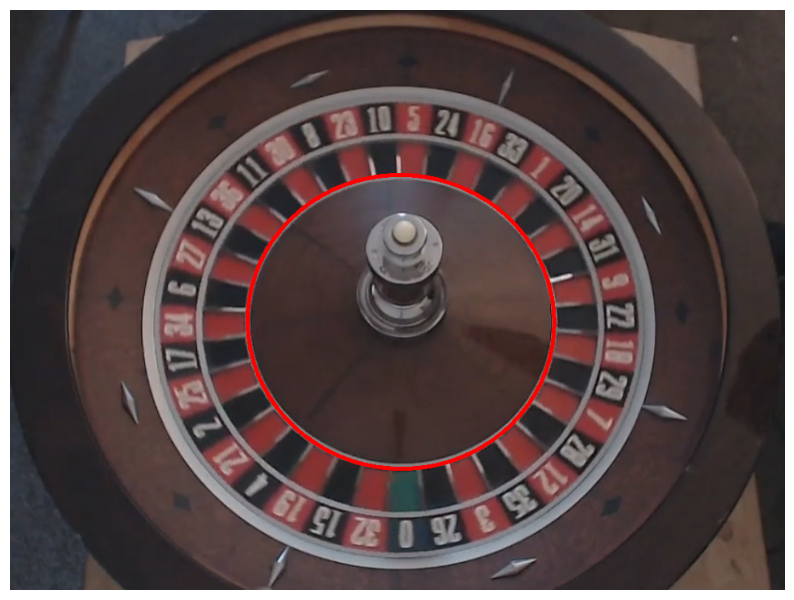

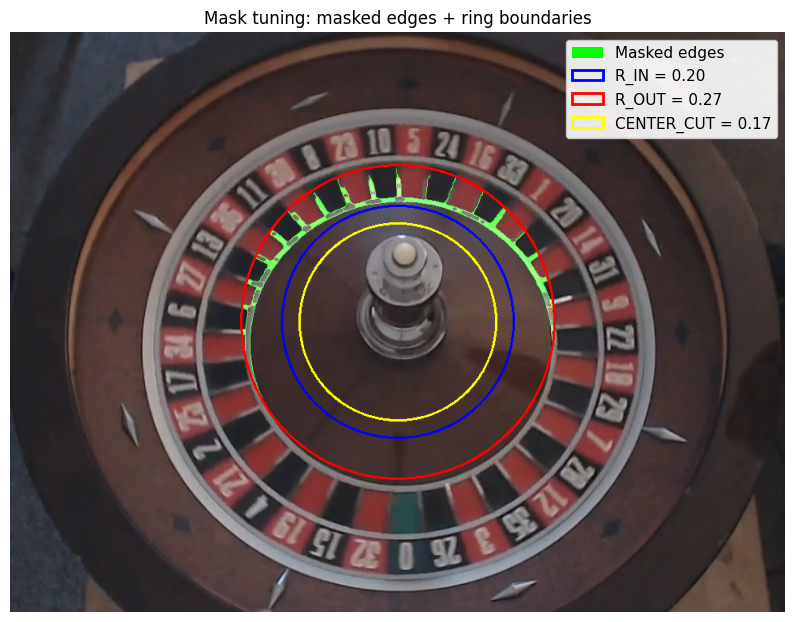

In [54]:
# 4) Draw result + save debug
vis = frame.copy()
cv2.ellipse(vis, ellipse, (0, 0, 255), 3)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Build visualization image
tune_vis = frame.copy()

# Green overlay for masked edges
overlay = np.zeros_like(frame)
overlay[edges_masked > 0] = (0, 255, 0)
alpha = 0.75
tune_vis = cv2.addWeighted(tune_vis, 1.0, overlay, alpha, 0)

# Draw tuning circles
cv2.circle(tune_vis, (cx0, cy0), r_in,         (255, 0, 0), 2)    # Blue
cv2.circle(tune_vis, (cx0, cy0), r_out,        (0, 0, 255), 2)    # Red
cv2.circle(tune_vis, (cx0, cy0), r_center_cut, (0, 255, 255), 2)  # Yellow

# Display with legend
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(tune_vis, cv2.COLOR_BGR2RGB))
plt.axis("off")

legend_elements = [
    Patch(facecolor=(0/255, 255/255, 0/255), edgecolor='none', label="Masked edges"),
    Patch(facecolor='none', edgecolor=(0/255, 0/255, 255/255), linewidth=2, label=f"R_IN = {R_IN:.2f}"),
    Patch(facecolor='none', edgecolor=(255/255, 0/255, 0/255), linewidth=2, label=f"R_OUT = {R_OUT:.2f}"),
    Patch(facecolor='none', edgecolor=(255/255, 255/255, 0/255), linewidth=2, label=f"CENTER_CUT = {CENTER_CUT:.2f}")
]

plt.legend(handles=legend_elements,
           loc="upper right",
           framealpha=0.9,
           fontsize=11)

plt.title("Mask tuning: masked edges + ring boundaries")
plt.show()